### In this notebook:
LSTM Networks take as input:
- ERA5 timeseries
- MJO_ENSO timeseries

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
os.chdir('./drive/My Drive/Tropical_Cyclones_Thesis/ERA5_Dataset')

In [3]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas.api.types import CategoricalDtype
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime
from keras.models import load_model


import pickle
import metrics
import datashift

In [4]:
import tensorflow as tf
tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)

2.15.0


 # Loading Datasets

In [5]:
df_era5 = pd.read_csv('./DATASET_COMPLETED/ensemble_dataset/ERA5_16zones_avg_std_10D.csv')
df_era5 = df_era5.set_index('DATE')
df_era5 = df_era5.drop(columns=['S.IndAll', 'S.IndGen'])
df_era5 = df_era5[df_era5.index > '1980-02']
df_era5 = df_era5[df_era5.index < '2022']

# Create MinMaxScaler instance
scaler = MinMaxScaler()
# Fit the scaler on the reshaped dataset and transform it
data_scaled = scaler.fit_transform(df_era5)
df_era5_scaled = pd.DataFrame(data_scaled, columns=df_era5.columns)
df_era5_scaled.index = df_era5.index
df_era5_scaled

,P_Mean_Z1-0,P_Mean_Z1-1,P_Mean_Z1-2,P_Mean_Z1-3,P_Mean_Z1-4,P_Mean_Z1-5,P_Mean_Z1-6,P_Mean_Z1-7,P_Mean_Z1-8,P_Mean_Z1-9,...,Air_Density_Std_Z16-1,Air_Density_Std_Z16-2,Air_Density_Std_Z16-3,Air_Density_Std_Z16-4,Air_Density_Std_Z16-5,Air_Density_Std_Z16-6,Air_Density_Std_Z16-7,Air_Density_Std_Z16-8,Air_Density_Std_Z16-9,Air_Density_Std_Z16-10
DATE,,,,,,,,,,,,,,,,,,,,,
1980-02-01,0.400255,0.364918,0.382609,0.416793,0.386992,0.370588,0.361763,0.434279,0.449898,0.489865,...,0.318328,0.273482,0.336515,0.403900,0.353448,0.402396,0.425584,0.422273,0.409480,0.392453
1980-02-02,0.412313,0.400255,0.364918,0.382609,0.416793,0.386992,0.370588,0.361763,0.434279,0.449898,...,0.376670,0.318328,0.273482,0.336515,0.403900,0.353448,0.402396,0.425584,0.422273,0.409480
1980-02-03,0.376618,0.412313,0.400255,0.364918,0.382609,0.416793,0.386992,0.370588,0.361763,0.434279,...,0.404121,0.376670,0.318328,0.273482,0.336515,0.403900,0.353448,0.402396,0.425584,0.422273
1980-02-04,0.348375,0.376618,0.412313,0.400255,0.364918,0.382609,0.416793,0.386992,0.370588,0.361763,...,0.363910,0.404121,0.376670,0.318328,0.273482,0.336515,0.403900,0.353448,0.402396,0.425584
1980-02-05,0.286090,0.348375,0.376618,0.412313,0.400255,0.364918,0.382609,0.416793,0.386992,0.370588,...,0.286136,0.363910,0.404121,0.376670,0.318328,0.273482,0.336515,0.403900,0.353448,0.402396
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-27,0.459871,0.451993,0.383920,0.367969,0.454867,0.508562,0.545995,0.502857,0.513174,0.509506,...,0.425590,0.517221,0.435563,0.443043,0.280731,0.299484,0.300563,0.262145,0.261458,0.382929
2021-12-28,0.489694,0.459871,0.451993,0.383920,0.367969,0.454867,0.508562,0.545995,0.502857,0.513174,...,0.293302,0.425590,0.517221,0.435563,0.443043,0.280731,0.299484,0.300563,0.262145,0.261458
2021-12-29,0.429117,0.489694,0.459871,0.451993,0.383920,0.367969,0.454867,0.508562,0.545995,0.502857,...,0.255346,0.293302,0.425590,0.517221,0.435563,0.443043,0.280731,0.299484,0.300563,0.262145


In [6]:
df_mjo = pd.read_csv('./DATASET_COMPLETED/ensemble_dataset/MJO_30D_scaled.csv')
df_enso = pd.read_csv('./DATASET_COMPLETED/ensemble_dataset/ENSO_30D_scaled.csv')
df_target = pd.read_csv('./DATASET_COMPLETED/old_dataset/tc_act_sind.csv')

In [7]:
def rewind_att(att_list, steps):
  new_list = []
  for elem in att_list:
    for i in range(steps):
      new_list.append('{}-{}'.format(elem,i+1))
  return new_list

attributes_list = ['RMM1', 'RMM2', 'Phase', 'nino3', 'nino4', 'nino12', 'nino34', 'indocW','indocE']
#attributes_selected = ['RMM1', 'RMM2', 'Phase', 'indocW', 'indocE']
attributes_selected = ['RMM1', 'RMM2', 'Phase', 'nino3', 'nino4', 'nino12', 'nino34', 'indocW','indocE']

df_mjo_enso = pd.merge(df_mjo, df_enso, on=["DATE"])
df_mjo_enso = df_mjo_enso.set_index('DATE')
df_mjo_enso = df_mjo_enso[df_mjo_enso.index < '2022']
df_mjo_enso = df_mjo_enso[rewind_att(attributes_selected, 30)]

#print(len(df_mjo), len(df_enso), len(df_mjo_enso))
df_mjo_enso

,RMM1-1,RMM1-2,RMM1-3,RMM1-4,RMM1-5,RMM1-6,RMM1-7,RMM1-8,RMM1-9,RMM1-10,...,indocE-21,indocE-22,indocE-23,indocE-24,indocE-25,indocE-26,indocE-27,indocE-28,indocE-29,indocE-30
DATE,,,,,,,,,,,,,,,,,,,,,
1980-02-01,0.443395,0.497201,0.543049,0.533406,0.520222,0.496491,0.477807,0.479205,0.484783,0.492725,...,0.550539,0.539860,0.529143,0.519671,0.512739,0.512140,0.518311,0.527535,0.536084,0.540251
1980-02-02,0.426263,0.443395,0.497201,0.543049,0.533406,0.520222,0.496491,0.477807,0.479205,0.484783,...,0.559889,0.550539,0.539860,0.529143,0.519671,0.512739,0.512140,0.518311,0.527535,0.536084
1980-02-03,0.446730,0.426263,0.443395,0.497201,0.543049,0.533406,0.520222,0.496491,0.477807,0.479205,...,0.564371,0.559889,0.550539,0.539860,0.529143,0.519671,0.512739,0.512140,0.518311,0.527535
1980-02-04,0.477843,0.446730,0.426263,0.443395,0.497201,0.543049,0.533406,0.520222,0.496491,0.477807,...,0.562821,0.564371,0.559889,0.550539,0.539860,0.529143,0.519671,0.512739,0.512140,0.518311
1980-02-05,0.482835,0.477843,0.446730,0.426263,0.443395,0.497201,0.543049,0.533406,0.520222,0.496491,...,0.557513,0.562821,0.564371,0.559889,0.550539,0.539860,0.529143,0.519671,0.512739,0.512140
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-27,0.456721,0.459083,0.487810,0.506327,0.522359,0.524730,0.508447,0.536899,0.574846,0.597357,...,0.585440,0.580454,0.595150,0.576959,0.601620,0.613510,0.615770,0.612231,0.609712,0.605784
2021-12-28,0.430960,0.456721,0.459083,0.487810,0.506327,0.522359,0.524730,0.508447,0.536899,0.574846,...,0.613950,0.585440,0.580454,0.595150,0.576959,0.601620,0.613510,0.615770,0.612231,0.609712
2021-12-29,0.412768,0.430960,0.456721,0.459083,0.487810,0.506327,0.522359,0.524730,0.508447,0.536899,...,0.606413,0.613950,0.585440,0.580454,0.595150,0.576959,0.601620,0.613510,0.615770,0.612231


In [8]:
df_target = df_target.rename(columns={'Unnamed: 0': 'DATE'})
df_target = df_target.set_index('DATE')
df_target['Label'] = df_target['S.IndAll'].apply(lambda x: 1 if x > 0 else 0)
df_target = df_target[df_target.index > '1980-02']
df_target = df_target[df_target.index < '2022']
df_target = df_target['Label']

df_target

DATE
1980-02-01    1
1980-02-02    1
1980-02-03    1
1980-02-04    1
1980-02-05    1
             ..
2021-12-27    0
2021-12-28    0
2021-12-29    0
2021-12-30    0
2021-12-31    0
Name: Label, Length: 15310, dtype: int64

## Build timeseries

In [9]:
def build_timeseries(df, N_samples, len_timeseries, N_vars):
  timeseries_arr = np.zeros((N_samples, len_timeseries, N_vars))
  arr = df.values
  i = 0
  for elem in arr:
    j = 0
    for var_idx in range(N_vars):
        idx = var_idx*len_timeseries
        timeseries_arr[i, :, j] = elem[idx : idx + len_timeseries]
        j += 1
    i += 1
  return timeseries_arr

valid_set = True

if valid_set:
  X_train_mjo = build_timeseries(df_mjo_enso[df_mjo_enso.index < '2002'], len(df_mjo_enso[df_mjo_enso.index < '2002']), 30, 5)
  X_train_era5 = build_timeseries(df_era5_scaled[df_era5_scaled.index < '2002'], len(df_era5_scaled[df_era5_scaled.index < '2002']), 11, 608)
  y_train = df_target[df_target.index < '2002'].values

  df_mjo_valid = df_mjo_enso[df_mjo_enso.index > '2002']
  df_mjo_valid = df_mjo_valid[df_mjo_valid.index < '2012']
  df_era5_valid = df_era5_scaled[df_era5_scaled.index > '2002']
  df_era5_valid = df_era5_valid[df_era5_valid.index < '2012']
  df_target_valid = df_target[df_target.index > '2002']
  df_target_valid = df_target_valid[df_target_valid.index < '2012']

  X_valid_mjo = build_timeseries(df_mjo_valid, len(df_mjo_valid), 30, 5)
  X_valid_era5 = build_timeseries(df_era5_valid, len(df_era5_valid), 11, 608)
  y_valid = df_target_valid.values

  X_test_mjo = build_timeseries(df_mjo_enso[df_mjo_enso.index > '2012'], len(df_mjo_enso[df_mjo_enso.index > '2012']), 30, 5)
  X_test_era5 = build_timeseries(df_era5_scaled[df_era5_scaled.index > '2012'], len(df_era5_scaled[df_era5_scaled.index > '2012']), 11, 608)
  y_test = df_target[df_target.index > '2012'].values
else:
  X_train_mjo = build_timeseries(df_mjo_enso[df_mjo_enso.index < '2012'], len(df_mjo_enso[df_mjo_enso.index < '2012']), 30, 5)
  X_train_era5 = build_timeseries(df_era5_scaled[df_era5_scaled.index < '2012'], len(df_era5_scaled[df_era5_scaled.index < '2012']), 11, 608)
  y_train = df_target[df_target.index < '2012'].values

  X_test_mjo = build_timeseries(df_mjo_enso[df_mjo_enso.index > '2012'], len(df_mjo_enso[df_mjo_enso.index > '2012']), 30, 5)
  X_test_era5 = build_timeseries(df_era5_scaled[df_era5_scaled.index > '2012'], len(df_era5_scaled[df_era5_scaled.index > '2012']), 11, 608)
  y_test = df_target[df_target.index > '2012'].values



print('TRAIN SET: ')
print('MJO    --> ', X_train_mjo.shape)
print('ERA5   --> ', X_train_era5.shape)
print('TARGET --> ', y_train.shape)

print('VALID SET: ')
print('MJO    --> ', X_valid_mjo.shape)
print('ERA5   --> ', X_valid_era5.shape)
print('TARGET --> ', y_valid.shape)

print('TEST SET: ')
print('MJO    --> ', X_test_mjo.shape)
print('ERA5   --> ', X_test_era5.shape)
print('TARGET --> ', y_test.shape)

TRAIN SET: 
MJO    -->  (8005, 30, 5)
ERA5   -->  (8005, 11, 608)
TARGET -->  (8005,)
VALID SET: 
MJO    -->  (3652, 30, 5)
ERA5   -->  (3652, 11, 608)
TARGET -->  (3652,)
TEST SET: 
MJO    -->  (3653, 30, 5)
ERA5   -->  (3653, 11, 608)
TARGET -->  (3653,)


In [10]:
8005+3652+3653

15310

In [11]:
X_train_future_mjo = []
X_train_future_era5 = []
X_valid_future_mjo = []
X_valid_future_era5 = []
X_test_future_mjo = []
X_test_future_era5 = []

y_train_future = []
y_valid_future = []
y_test_future = []

for i in range(10):
  if i == 0:
    X_train_future_mjo.append(X_train_mjo)
    X_train_future_era5.append(X_train_era5)

    X_valid_future_mjo.append(X_valid_mjo)
    X_valid_future_era5.append(X_valid_era5)

    X_test_future_mjo.append(X_test_mjo)
    X_test_future_era5.append(X_test_era5)

    y_train_future.append(y_train)
    y_valid_future.append(y_valid)
    y_test_future.append(y_test)
  else:
    X_train_future_mjo.append(X_train_mjo[:-i])
    X_train_future_era5.append(X_train_era5[:-i])

    X_valid_future_mjo.append(X_valid_mjo[:-i])
    X_valid_future_era5.append(X_valid_era5[:-i])

    X_test_future_mjo.append(X_test_mjo[:-i])
    X_test_future_era5.append(X_test_era5[:-i])

    y_train_future.append(y_train[i:])
    y_valid_future.append(y_valid[i:])
    y_test_future.append(y_test[i:])

  print('t+{}'.format(i+1))
  print('TRAIN SET: ')
  print('MJO    --> ', X_train_future_mjo[i].shape)
  print('ERA5   --> ', X_train_future_era5[i].shape)
  print('TARGET --> ', y_train_future[i].shape)

  print('VALID SET: ')
  print('MJO    --> ', X_valid_future_mjo[i].shape)
  print('ERA5   --> ', X_valid_future_era5[i].shape)
  print('TARGET --> ', y_valid_future[i].shape)

  print('TEST SET: ')
  print('MJO    --> ', X_test_future_mjo[i].shape)
  print('ERA5   --> ', X_test_future_era5[i].shape)
  print('TARGET --> ', y_test_future[i].shape)
  print('-------------------------------------------------')

t+1
TRAIN SET: 
MJO    -->  (8005, 30, 5)
ERA5   -->  (8005, 11, 608)
TARGET -->  (8005,)
VALID SET: 
MJO    -->  (3652, 30, 5)
ERA5   -->  (3652, 11, 608)
TARGET -->  (3652,)
TEST SET: 
MJO    -->  (3653, 30, 5)
ERA5   -->  (3653, 11, 608)
TARGET -->  (3653,)
-------------------------------------------------
t+2
TRAIN SET: 
MJO    -->  (8004, 30, 5)
ERA5   -->  (8004, 11, 608)
TARGET -->  (8004,)
VALID SET: 
MJO    -->  (3651, 30, 5)
ERA5   -->  (3651, 11, 608)
TARGET -->  (3651,)
TEST SET: 
MJO    -->  (3652, 30, 5)
ERA5   -->  (3652, 11, 608)
TARGET -->  (3652,)
-------------------------------------------------
t+3
TRAIN SET: 
MJO    -->  (8003, 30, 5)
ERA5   -->  (8003, 11, 608)
TARGET -->  (8003,)
VALID SET: 
MJO    -->  (3650, 30, 5)
ERA5   -->  (3650, 11, 608)
TARGET -->  (3650,)
TEST SET: 
MJO    -->  (3651, 30, 5)
ERA5   -->  (3651, 11, 608)
TARGET -->  (3651,)
-------------------------------------------------
t+4
TRAIN SET: 
MJO    -->  (8002, 30, 5)
ERA5   -->  (8002, 11, 60

In [12]:
for i in range(10):
  np.save('./10_Black_Boxes/test_sets/X_test_lstm_mjo_t+{}.npy'.format(i+1), X_test_future_mjo[i])
  np.save('./10_Black_Boxes/test_sets/X_test_lstm_era5_t+{}.npy'.format(i+1), X_test_future_era5[i])
  np.save('./10_Black_Boxes/test_sets/y_test_lstm_t+{}.npy'.format(i+1), y_test_future[i])

In [15]:
loaded = np.load('./10_Black_Boxes/test_sets/y_test_lstm_t+4.npy')
print(loaded.shape)

(3650,)


# Evalute models

In [ ]:
from keras.models import load_model

max_lead_time = 10
models = []
for i in range(max_lead_time):
  models.append(load_model('./10_Black_Boxes/models/LSTM_Networks/LSTM_MJO_ENSO_ERA5_t+{}.h5'.format(i)))

In [ ]:
print(X_test_future_mjo[0].shape, X_test_future_era5[0].shape)

(3653, 30, 5) (3653, 11, 608)


In [ ]:
i = 9
prediction_test = models[i].predict([X_test_future_mjo[i], X_test_future_era5[i]]).transpose()[0]
print(prediction_test[0:1000])

In [ ]:
from metrics import TCStats
import sklearn

res_test    = []
predictions = []
predictions_bin = []

for i in range(10):
  print('Evaluation at t+{}'.format(i+1))

  prediction_test = models[i].predict([X_test_future_mjo[i], X_test_future_era5[i]]).transpose()[0]
  predictions.append(prediction_test)
  prediction_test[prediction_test >= 0.5] = 1
  prediction_test[prediction_test < 0.5] = 0
  predictions_bin.append(prediction_test)

  accuracy = sklearn.metrics.accuracy_score(y_test_future[i], prediction_test)
  recall   = sklearn.metrics.recall_score(y_test_future[i], prediction_test)
  f1       = sklearn.metrics.f1_score(y_test_future[i], prediction_test)

  print('ACCURACY: ', accuracy, 'RECALL: ', recall, 'F1: ', f1)
  print('------------------------------------------------------')

Evaluation at t+1
115/115 [==============================] - 10s 70ms/step
ACCURACY:  0.8792773063235697 RECALL:  0.8366141732283464 F1:  0.6584043377226956
------------------------------------------------------
Evaluation at t+2
115/115 [==============================] - 12s 80ms/step
ACCURACY:  0.8849945235487404 RECALL:  0.8165680473372781 F1:  0.6634615384615385
------------------------------------------------------
Evaluation at t+3
115/115 [==============================] - 11s 78ms/step
ACCURACY:  0.8247055601205149 RECALL:  0.8478260869565217 F1:  0.5727636849132176
------------------------------------------------------
Evaluation at t+4
115/115 [==============================] - 12s 82ms/step
ACCURACY:  0.8457534246575342 RECALL:  0.7841584158415842 F1:  0.5845018450184503
------------------------------------------------------
Evaluation at t+5
115/115 [==============================] - 11s 78ms/step
ACCURACY:  0.8141956700465881 RECALL:  0.7936507936507936 F1:  0.541271989174

In [ ]:
def brier_skill_score(y_true, y_prob):
    """
    Calculate Brier Skill Score.

    Parameters:
    - y_true: numpy array or pandas Series, true binary labels (0 or 1).
    - y_prob: numpy array or pandas Series, predicted probabilities for the positive class.

    Returns:
    - Brier Skill Score
    """
    # Ensure inputs are numpy arrays
    y_true = np.array(y_true)
    y_prob = np.array(y_prob)

    # Brier Score for the model (predicted probabilities)
    brier_model = np.mean((y_true - y_prob)**2)

    # Brier Score for the climatology (mean of true labels)
    brier_climatology = np.mean((y_true - np.mean(y_true))**2)

    # Brier Skill Score
    brier_skill_score = 1 - (brier_model / brier_climatology)

    return brier_skill_score


bss = []
for i in range(10):
  bss.append(brier_skill_score(y_test_future[i], predictions[i]))
  print('BRIER SKILL SCORE AT t+{}: '.format(i+1), brier_skill_score(y_test_future[i], predictions[i]))

BRIER SKILL SCORE AT t+1:  -0.00833281173716549
BRIER SKILL SCORE AT t+2:  0.03805232312019646
BRIER SKILL SCORE AT t+3:  -0.46831974964967293
BRIER SKILL SCORE AT t+4:  -0.2938657935745874
BRIER SKILL SCORE AT t+5:  -0.5608183814066168
BRIER SKILL SCORE AT t+6:  -0.510453969347666
BRIER SKILL SCORE AT t+7:  -0.7186376908898586
BRIER SKILL SCORE AT t+8:  -0.5339050920997945
BRIER SKILL SCORE AT t+9:  -0.6591911596654021
BRIER SKILL SCORE AT t+10:  -0.4440454121981934


## Plot results

In [ ]:
test_accuracy = []
test_recall = []
test_f1 = []
test_precision = []
test_far = []
for i in range(10):
    accuracy    = sklearn.metrics.accuracy_score(y_test_future[i], predictions[i])
    recall      = sklearn.metrics.recall_score(y_test_future[i], predictions[i])
    precision   = sklearn.metrics.precision_score(y_test_future[i], predictions[i])
    f1          = sklearn.metrics.f1_score(y_test_future[i], predictions[i])

    test_accuracy.append(accuracy)
    test_recall.append(recall)
    test_f1.append(f1)
    test_precision.append(precision)

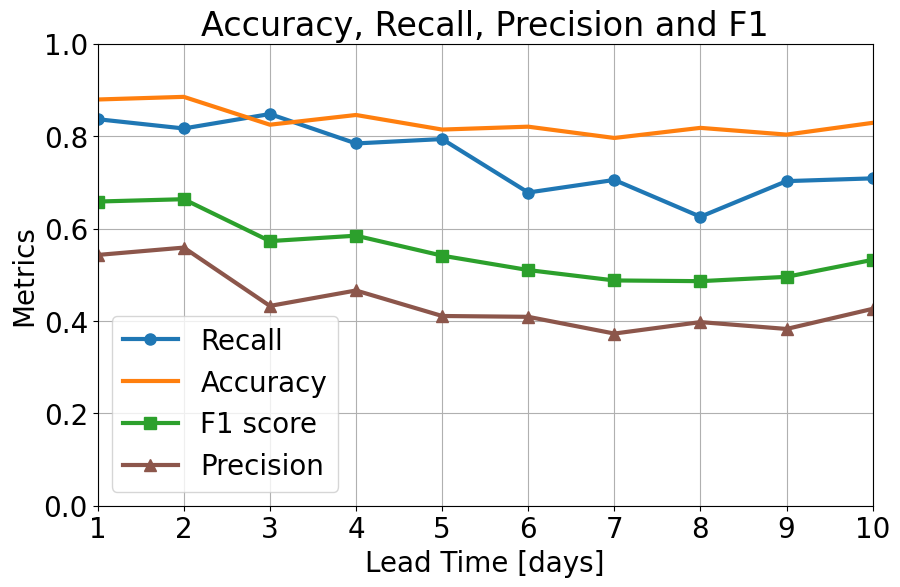

In [ ]:
import matplotlib

x = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

matplotlib.rcParams.update({'font.size': 20})

plt.figure(figsize=(10, 6))  # Adjust width and height as needed
# Assuming df_metrics_test, test_pod, and test_acc are already defined
# Plotting POD
plt.plot(x, test_recall, label='Recall', marker='o', color='C0', linewidth=3, markersize=8)
# Plotting Accuracy
plt.plot(x, test_accuracy, label='Accuracy', color='C1', linewidth=3, markersize=8)
# Plotting F1
plt.plot(x, test_f1, label='F1 score', marker='s', color='C2', linewidth=3, markersize=8)
# Plotting Precision
plt.plot(x, test_precision, label='Precision', marker='^', color='C5', linewidth=3, markersize=8)


plt.xlim(1, 10)  # Adjust the range based on your data
plt.ylim(0, 1)  # Adjust the range based on your data
plt.xticks(x)

# Adding labels and title
plt.xlabel('Lead Time [days]')
plt.ylabel('Metrics')
plt.title('Accuracy, Recall, Precision and F1')
plt.grid()
# Adding legend
plt.legend()

# Display the plot
plt.show()

In [ ]:
bss_perc = [elem*100 for elem in bss]

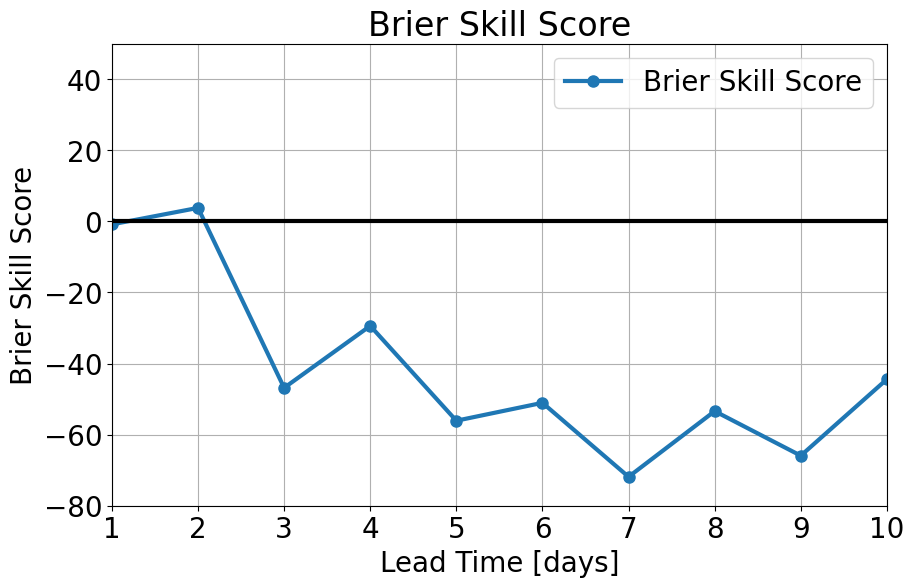

In [ ]:
x = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

plt.figure(figsize=(10, 6))  # Adjust width and height as needed
# Plotting BSS
plt.plot(x, bss_perc, label='Brier Skill Score', marker='o', color='C0', linewidth=3, markersize=8)

plt.xlim(1, 10)  # Adjust the range based on your data
plt.ylim(-80, 50)  # Adjust the range based on your data
plt.xticks(x)

plt.axhline(y=0, color='black', linewidth=3)
# Adding labels and title
plt.xlabel('Lead Time [days]')
plt.ylabel('Brier Skill Score')
plt.title('Brier Skill Score')
plt.grid()
# Adding legend
plt.legend()

# Display the plot
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix

tp_arr = []
tn_arr = []
fp_arr = []
fn_arr = []

for i in range(10):
  tn, fp, fn, tp = confusion_matrix(y_test_future[i], predictions_bin[i]).ravel()
  tp_arr.append(tp)
  tn_arr.append(tn)
  fp_arr.append(fp)
  fn_arr.append(fn)

  # print('t+{}'.format(i+1))
  # print("True Negative:", tn)
  # print("False Positive:", fp)
  # print("False Negative:", fn)
  # print("True Positive:", tp)
  # print('--------------------------')

In [ ]:
print(fp)

478


In [ ]:
far = []

for i in range(10):
  far.append(fp_arr[i]/(fp_arr[i]+tp_arr[i]))

print(far)

[0.45721583652618136, 0.44129554655870445, 0.5675403225806451, 0.5341176470588235, 0.5893223819301848, 0.5911270983213429, 0.6273684210526316, 0.6025316455696202, 0.6173913043478261, 0.5738295318127251]


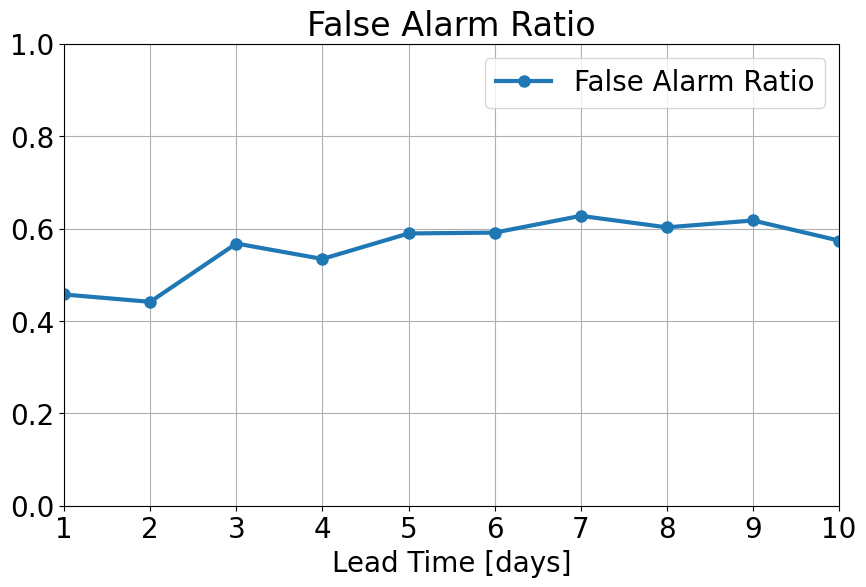

In [ ]:
x = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

plt.figure(figsize=(10, 6))  # Adjust width and height as needed
# Plotting BSS
plt.plot(x, far, label='False Alarm Ratio', marker='o', color='C0', linewidth=3, markersize=8)

plt.xlim(1, 10)  # Adjust the range based on your data
plt.ylim(0, 1)  # Adjust the range based on your data
plt.xticks(x)

# plt.axhline(y=0, color='black', linewidth=3)
# Adding labels and title
plt.xlabel('Lead Time [days]')
plt.title('False Alarm Ratio')
plt.grid()
# Adding legend
plt.legend()

# Display the plot
plt.show()

In [ ]:
print(tp_arr)
print(tn_arr)
print(fp_arr)
print(fn_arr)

[425, 414, 429, 396, 400, 341, 354, 314, 352, 355]
[2787, 2818, 2582, 2691, 2571, 2652, 2549, 2668, 2576, 2665]
[358, 327, 563, 454, 574, 493, 596, 476, 568, 478]
[83, 93, 77, 109, 104, 162, 148, 188, 149, 146]


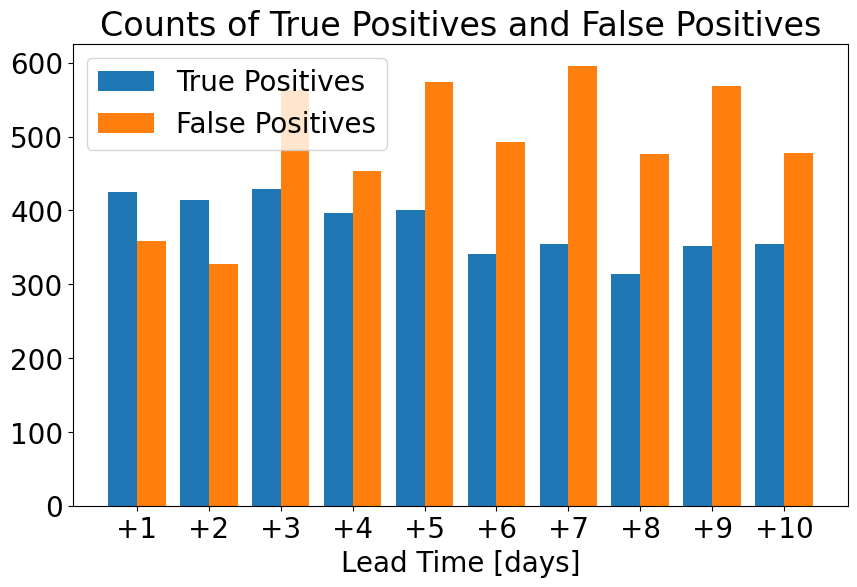

In [ ]:
# Data
days = ['+1', '+2', '+3', '+4', '+5', '+6', '+7', '+8', '+9', '+10']

fig, ax = plt.subplots(figsize=(10,6))


# Bar width
bar_width = 0.4

# Positions for the bars
pos_tp = range(len(days))
pos_fp = [p + bar_width for p in pos_tp]

# Plot tp and tn
ax.bar(pos_tp, tp_arr, width=bar_width, label='True Positives')
ax.bar(pos_fp, fp_arr, width=bar_width, label='False Positives')

# Set x-axis ticks and labels
ax.set_xticks([p + bar_width / 2 for p in pos_tp])
ax.set_xticklabels(days)

# Add labels and legend
ax.set_xlabel('Lead Time [days]')
ax.set_ylabel('')
ax.set_title('Counts of True Positives and False Positives')
ax.legend()

plt.show()

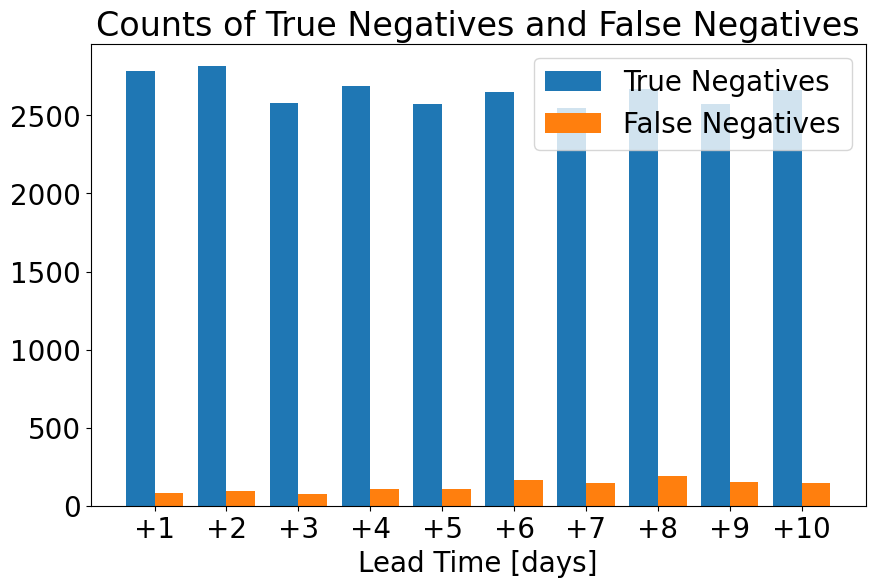

In [ ]:
# Data
days = ['+1', '+2', '+3', '+4', '+5', '+6', '+7', '+8', '+9', '+10']

fig, ax = plt.subplots(figsize=(10,6))


# Bar width
bar_width = 0.4

# Positions for the bars
pos_tn = range(len(days))
pos_fn = [p + bar_width for p in pos_tn]

# Plot tp and tn
ax.bar(pos_tn, tn_arr, width=bar_width, label='True Negatives')
ax.bar(pos_fn, fn_arr, width=bar_width, label='False Negatives')

# Set x-axis ticks and labels
ax.set_xticks([p + bar_width / 2 for p in pos_tp])
ax.set_xticklabels(days)

# Add labels and legend
ax.set_xlabel('Lead Time [days]')
ax.set_ylabel('')
ax.set_title('Counts of True Negatives and False Negatives')
ax.legend()

plt.show()